Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

### Инструкция по выполнению проекта

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

### Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [2]:
#!pip install pywsd

In [ ]:
#!pip install catboost

In [ ]:
#!pip install transformers

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords as nltk_stopwords
from tqdm import notebook
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
import torch
import transformers as ppb

In [7]:
#from pywsd.utils import lemmatize_sentence
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
import resource, sys
resource.setrlimit(resource.RLIMIT_STACK, (2**29,-1))
sys.setrecursionlimit(10**6)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [10]:
df = pd.read_csv('/content/drive/My Drive/datasets/toxic_comments.csv')

In [11]:
df

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


In [12]:
df['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

# 1. Подготовка

Отчистка текстовых сообщение от неинформативных символов включает в себя следующую
последовательность действий:
1. Замена символа табуляции и тире на символ пробела;
2. Удаление спецсимволов HTML;
3. Удаление всех символов, кроме букв латинского алфавита, также удаляем числа, поскольку они не оказывают влияния на тональность текста.

In [ ]:
corpus = df['text']
def preprocess_text(text):
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'USER', text)
    text = re.sub('[^a-zA-Z]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.strip()


clear_data = [preprocess_text(t) for t in corpus]

In [ ]:
def lemmatize(text):
  sentence = []
  for sent in notebook.tqdm(clear_data):
    lemm_sentence = ' '.join(lemmatize_sentence(sent))
    sentence.append(lemm_sentence)
  return sentence   
    
lemm_text = lemmatize(clear_data)

In [ ]:
df['lemm_text'] = lemm_text
df.to_csv('lemm_text.csv')

In [13]:
preprocessed_data = pd.read_csv('/content/drive/My Drive/datasets/lemm_text.csv')
preprocessed_data = preprocessed_data.drop('Unnamed: 0', axis=1)

In [14]:
preprocessed_data[preprocessed_data['lemm_text'].isna()]

,text,toxic,lemm_text
4482,1993\n\n1994\n\n1995\n\n1996\n\n1997\n\n1998\n...,0,NaN
6300,193.61.111.53 15:00,0,NaN
17311,~ \n\n68.193.147.157,0,NaN
52442,"14:53,",0,NaN
53787,92.24.199.233|92.24.199.233]],0,NaN
61758,"""\n\n 199.209.144.211 """,0,NaN
82681,"""\n '''''' 2010/2013 """,0,NaN


Текст очищен и лемматизирован. Мы видим, что изначально был странный текст, который лемматизатор не смог привести к лемме, из-за этого образовались пропуски в лемматизированном тексте, их надо удалить. Также проверим наличие дублей, поскольку они могут случайным образом оказаться в обучающей и тестовой выборке.


In [15]:
preprocessed_data = preprocessed_data.dropna(how='any')

In [16]:
print("Пропуски:", preprocessed_data['lemm_text'].isna().sum())
print("Дубликаты:",preprocessed_data.duplicated().sum())

Пропуски: 0
Дубликаты: 0


In [17]:
preprocessed_data

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...
...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,and for the second time of ask when your view ...
159567,You should be ashamed of yourself \n\nThat is ...,0,you should be ashamed of yourself that be a ho...
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer umm theres no actual article for prost...
159569,And it looks like it was actually you who put ...,0,and it look like it be actually you who put on...


Получили лемматизированный текст в нижнем регистре (некоторые модели чувствительны к нему).


count    159564.000000
mean         67.723584
std         100.442599
min           1.000000
25%          17.000000
50%          36.000000
75%          76.000000
max        1403.000000
Name: lemm_text, dtype: float64


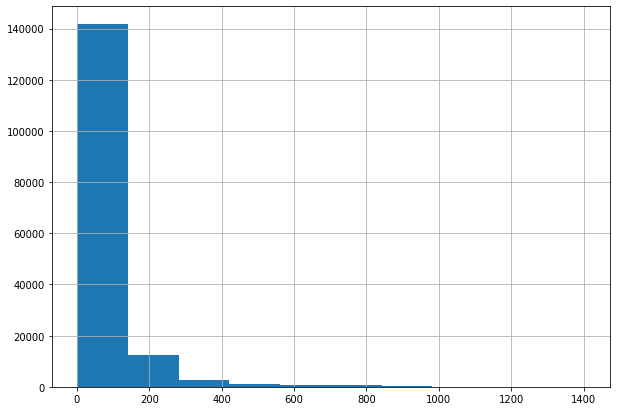

In [18]:
preprocessed_data['lemm_text'].apply(lambda x: len(x.split())).hist(figsize=(10,7))
print()
print(preprocessed_data['lemm_text'].apply(lambda x: len(x.split())).describe())

На гистограмме выше можно увидеть, что около 90% всех предложений состоят примерно из 100 слов.

Создадим матрицу признаков с частотностью слов с помощью TF-IDF. 
Это простой и удобный способ оценить важность термина для какого-либо документа относительно всех остальных документов. Принцип такой — если слово встречается в каком-либо документе часто, при этом встречаясь редко во всех остальных документах — это слово имеет большую значимость для того самого документа. При этом слова, неважные для вообще всех документов, например, предлоги или междометия — получат очень низкий вес TF-IDF (потому что часто встречаются во всех-всех документах), а важные — высокий.

In [19]:
x = preprocessed_data['lemm_text']
y = preprocessed_data['toxic']

In [20]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y,                                                    
                                                      test_size=0.2,
                                                      random_state=42)                                                                       
                                                                           
x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid,
                                                    test_size=0.5,
                                                    random_state=42)

In [23]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words = stopwords)
x_train = count_tf_idf.fit_transform(x_train)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
x_valid = count_tf_idf.transform(x_valid)
x_test = count_tf_idf.transform(x_test)

# 2. Обучение

**Логистическая регрессия**

In [25]:
from sklearn.metrics import confusion_matrix

In [26]:
%%time
regr_model = LogisticRegression(class_weight = 'balanced')
regr_model.fit(x_train, y_train)
predict = regr_model.predict(x_valid)
print('F1_sccore:', f1_score(y_valid, predict))
print()
print('Матрица ошибок')
print(confusion_matrix(y_valid, predict))
print()

F1_sccore: 0.7462284482758621

Матрица ошибок
[[13629   729]
 [  213  1385]]

CPU times: user 7.96 s, sys: 5.4 s, total: 13.4 s
Wall time: 6.83 s


**CatBoost**

In [27]:
%%time
cat_model = CatBoostClassifier(eval_metric="F1", 
                                   iterations=100, 
                                   max_depth=6, 
                                   learning_rate=0.9, 
                                   random_state=42)
cat_model.fit(x_train, y_train, verbose=10)
prediction = cat_model.predict(x_valid)
print('F1_score:', f1_score(y_valid, prediction))
print()
print('Матрица ошибок')
print(confusion_matrix(y_valid, prediction))
print()

0:	learn: 0.4877175	total: 3.36s	remaining: 5m 32s
10:	learn: 0.7041864	total: 27.6s	remaining: 3m 43s
20:	learn: 0.7327108	total: 52.2s	remaining: 3m 16s
30:	learn: 0.7522359	total: 1m 15s	remaining: 2m 48s
40:	learn: 0.7688539	total: 1m 39s	remaining: 2m 23s
50:	learn: 0.7806987	total: 2m 4s	remaining: 1m 59s
60:	learn: 0.7868062	total: 2m 29s	remaining: 1m 35s
70:	learn: 0.7932302	total: 2m 54s	remaining: 1m 11s
80:	learn: 0.7969688	total: 3m 19s	remaining: 46.7s
90:	learn: 0.8021581	total: 3m 44s	remaining: 22.2s
99:	learn: 0.8067825	total: 4m 7s	remaining: 0us
F1_score: 0.7604642982764684

Матрица ошибок
[[14194   164]
 [  517  1081]]

CPU times: user 8min 34s, sys: 6.83 s, total: 8min 41s
Wall time: 4min 46s


# 3. Выводы

In [28]:
test_cat_predict = cat_model.predict(x_test)
print('F1_score СatBoost:', f1_score(y_test, test_cat_predict))
print()
print('Матрица ошибок')
print(confusion_matrix(y_test, test_cat_predict))
print()

F1_score СatBoost: 0.7523380671977832

Матрица ошибок
[[14156   188]
 [  527  1086]]



In [29]:
log_reg_predict = regr_model.predict(x_test)
print('F1_score Logistic Regression:', f1_score(y_test, log_reg_predict))
print()
print('Матрица ошибок')
print(confusion_matrix(y_test, log_reg_predict))
print()

F1_score Logistic Regression: 0.7458533975387909

Матрица ошибок
[[13613   731]
 [  219  1394]]



F1 score у бустинга и регрессии практически одинаковый. Тут выбор модели будет зависеть от задачи. Регрессия выдает больше ложноположительных результатов (в данном случае чаще ошибочно классифицирует текст как токсичный), зато меньше ложноотрицательных (комментарий действительно был токсичный, но модель его не распознала). Если задачей будет являться выявить как можно больше токсичных комментариев, чтобы их в дальнейшем в ручную обработать, то наш выбор - регрессия. 

**BERT**

Возьмем первые 500 строк для дальнейшей работы. Модель DistilBERT поддерживает максимум 512 слов в предложении, поэтому отсортируем наш батч и оставим только такие предложения, где количество слов <=512.

In [30]:
batch = preprocessed_data[['lemm_text','toxic']][:500]

In [31]:
batch

,lemm_text,toxic
0,explanation why the edits make under my userna...,0
1,d aww he match this background colour i m seem...,0
2,hey man i m really not try to edit war it s ju...,0
3,more i can t make any real suggestion on impro...,0
4,you sir be my hero any chance you remember wha...,0
...,...,...
495,sarek of vulcan unfortunately for you you can ...,0
496,keep your chin up darwinism be not accept over...,0
497,nazi filth be impolite jan utc,1
498,interest i check the other case number kunzang...,0


In [32]:
def filter_sentence(text):
  sentences = []
  for sentence in text['lemm_text']:
    split_sentence = sentence.split()
    if len(split_sentence) <= 400:
      sentences.append(' '.join(split_sentence))
  return sentences    

In [33]:
fitred_sentence = filter_sentence(batch)  

In [34]:
batch['lemm_text'] = batch['lemm_text'].where(batch['lemm_text'].isin(fitred_sentence))
batch = batch.dropna(subset=['lemm_text'], axis=0)
print('Пропуски:', batch.isna().sum())

Пропуски: lemm_text    0
toxic        0
dtype: int64


In [35]:
for s in batch['lemm_text']:
  if len(s.split()) > 400:
    print(s)

In [36]:
batch['toxic'].value_counts()

0    441
1     50
Name: toxic, dtype: int64

Загрузим уже предобученную модель. 

In [37]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Разобьем предложения на токены

In [38]:
tokenized = batch['lemm_text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

Токенизатор отработал без ошибок только тогда, когда в батче остались предложения до 400 слов.   
Далее идет padding. Поскольку количество токенов в каждом предложении получилось разное, чтобы получить обычную двумерную матрицу, необходимо заполнить нулями "отсутсвующие" токены в списке, чтобы список был одинаковой "ширины". 

In [39]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [40]:
np.array(padded).shape

(491, 374)

Получили матрицу с признакаи размером 491 на 374.  
Далее, надо объяснить модели, что те нули, которыми мы заполнили список для получения матрицы на предыдущем этапе, не имеют значения.

In [41]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(491, 374)

In [42]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

Поскольку BERT добавляет маркер [CLS] классификации в начале каждого предложения, то вывод, соответствующий этому токену, можно рассматривать как вложение для всего предложения. Матрица признаков, в этом случае, будет получена таким образом:

In [43]:
features = last_hidden_states[0][:,0,:].numpy()

In [44]:
targets = batch['toxic']

In [45]:
features_train, features_test, targets_train, targets_test = train_test_split(
    features, targets, test_size = 0.25,
    random_state=42
)

Данные для обучения готовы.

In [46]:
%%time
bert_model = LogisticRegression(class_weight = 'balanced')
bert_model.fit(features_train, targets_train)
predict = bert_model.predict(features_test)
print('F1_sccore:', f1_score(targets_test, predict))
print()
print('Матрица ошибок')
print(confusion_matrix(targets_test, predict))
print()

F1_sccore: 0.7027027027027027

Матрица ошибок
[[99  4]
 [ 7 13]]

CPU times: user 122 ms, sys: 66 ms, total: 188 ms
Wall time: 139 ms
